In [1]:
import os
import time
import pandas as pd
import numpy as np

In [2]:
# 设定一些基本不会经常变化的参数
class Config:  # 设定一些基本不会经常变化的参数
    # 数据参数
    feature_columns = list([0, 1, 3])  # 要作为feature的列，按原数据从0开始计算，也可以用list 如 [2,4,6,8] 设置
    label_columns = [3]  # 要预测的列，按原数据从0开始计算, 如：将来可以同时预测第日产油量和日产气量
    label_in_feature_index = (lambda x, y: [x.index(i) for i in y])(feature_columns, label_columns)
    static_nature_column = list(range(0, 4))  ## 区分静态特征的两类 前四个属于地质参数和流体物性参数	后面的属于工艺参数
    dynamic_length = len(feature_columns) - len(label_columns)
    static_human_column = list(range(4, 13))

    input_size = len(feature_columns)
    output_size = len(label_columns)

    naturesize = len(static_nature_column)
    humansize = len(static_human_column)

    name = 'name'
    roll_predict_day = 145  # 迭代预测未来天数
    # 网络参数

    save_data_cache = True  # 是否保存数据采样的结果
    embedding_size = 256  # 送入LSTM前升维
    hidden_size = 256  # LSTM的隐藏层大小，也是输出大小
    lstm_layers = 2  # LSTM的堆叠层数
    dropout_rate = 0.2  # dropout概率
    time_step = 0  # 这个参数很重要，是设置用前多少天的数据来预测，也是LSTM的time step数
    predict_day = 0  # 预测未来几天
    # 训练参数
    data_selected = []
    do_train = True
    do_predict = True
    do_predict_roll = True
    add_train = True  # 是否载入已有模型参数进行增量训练
    shuffle_train_data = False  # 是否对训练数据做shuffle #如果把上一batch的hc传入下一batch，shuffle必须为False
    use_cuda = True  # 是否使用GPU训练
    cudadevice = 'cuda:0'  # 如果不使用gpu就改成 cudadevice='cpu',不改也行，模型在gpu没法用的情况下自动使用cpu
    traindata = 'traindata'
    train_data_rate = 0.67  # 训练数据占总体数据比例，测试数据就是 1-train_data_rate
    valid_data_rate = 0.15  # 验证数据占训练数据比例，验证集在训练过程使用，为了做模型和参数选择

    batch_size = 0
    learning_rate = 0.00005
    epoch = 200  # 整个训练集被训练多少遍，不考虑早停的前提下
    patience = 5  # 训练多少epoch，验证集没提升就停掉
    random_seed = 42  # 随机种子，保证可复现

    # 框架参数
    used_frame = "pytorch"  # 选择的深度学习框架，不同的框架模型保存后缀不一样
    model_postfix = {"pytorch": ".pth"}
    model_name = model_postfix[used_frame]

    # 路径参数
    data_cache_path = 'cache'
    static_data_path = 'input/csv/static/All_static.csv'
    dynamic_data_root = 'input/csv/dynamic'
    model_save_path = "result/model/"
    figure_save_path = "result/figure/"
    log_save_path = "result/logs/"
    do_log_print_to_screen = True
    do_log_save_to_file = True  # 是否将config和训练过程记录到log
    do_figure_save = True
    do_train_visualized = False  # 训练loss可视化，pytorch用visdom,留着下次使用
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)  # makedirs 递归创建目录
    if not os.path.exists(figure_save_path):
        os.mkdir(figure_save_path)
    if do_train and (do_log_save_to_file or do_train_visualized):
        cur_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
        log_save_path = log_save_path + cur_time + '_' + used_frame + "/"
        os.makedirs(log_save_path)

In [5]:
# 损失函数
import torch
import torch.nn as nn
class RMSLEloss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(abs(pred + 1)), torch.log(abs(actual + 1))))

In [6]:
# 评估指标
import numpy as np
def mean_relative_error(predict, target):
    error = target-predict
    for i,j in  enumerate(error):
        error[i] =abs(j)
    mean_error = sum(error/target)/len(error)
    return mean_error


In [7]:
# ------------- 定义基本的模型框架 -------------------#
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from xpinyin import Pinyin
# from model.full_model_no_dynamic import Net
# from tool.loss.RMSLEloss import RMSLEloss
import setproctitle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from tool.evaluate.mean_relative_error import mean_relative_error

### 参数初始化

In [13]:
import argparse

# argparse方便于命令行下输入参数，可以根据需要增加更多
parser = argparse.ArgumentParser()
# 如果在linux下面, 可以方便采用下面的参数输入
# 在Windows环境下，可以单独修改参数，直接运行
parser.add_argument("-b", "--batch_size", default=16, type=int, help="batch size")
parser.add_argument("-e", "--epoch", default=100, type=int, help="epochs num")
parser.add_argument("--ttotrain", default=1, type=int, help="1代表训练,0代表测试")
parser.add_argument("--use_attention", default=1, type=int, help="seq2seq_attention")
parser.add_argument("--use_static_embedding", default=1, type=int, help="Inite,h0_c0")

parser.add_argument("--only_dynamic", default=0, type=int, help="只用动态嵌入")
parser.add_argument("--only_static_concat_dynamic", default=0, type=int, help="静态拼接动态降维")
parser.add_argument("--only_static_plus_dynamic", default=0, type=int, help="静态和动态直接相加")

parser.add_argument("--roll_predict_day", default=125, type=int, help="迭代预测天数")  # 相当于让Decoder迭代多少次

parser.add_argument("--predict_day", default=3, type=int, help="Decoder预测天数")
parser.add_argument("--time_step", default=5, type=int, help="Encoder读取天数")

parser.add_argument("--name", default='A1', type=str, help="填写训练预设名称")  # 可以填写'All' 或者'A1,B1,B590_1,B123'这种形式
parser.add_argument("--val_name", default='C1', type=str, help="填写测试预设名称")  # 填写'C1'这种形式，暂时只支持测试1口井
# only_dynamic only_static_concat_dynamic only_static_plus_dynamic
# args = parser.parse_args()
args = parser.parse_args(args=['--batch_size', '16',  '--epoch', '100', '--ttotrain', '1', '--use_attention', '1', '--use_static_embedding', '1', '--only_dynamic', '0', '--only_static_concat_dynamic', '0', '--only_static_plus_dynamic', '0', '--roll_predict_day', '125', '--predict_day', '3', '--time_step', '5', '--name', 'A1', '--val_name', 'C1'])


In [14]:
con = Config()
for key in dir(args):  # dir(args) 函数获得args所有的属性
    if not key.startswith("_"):  # 去掉 args 自带属性，比如__name__等
        setattr(con, key, getattr(args, key))  # 将属性值赋给Config
# 建议window下，采用下面, 便于调试

assert con.only_dynamic + con.only_static_concat_dynamic + con.only_static_plus_dynamic <= 1
# 这几个参数做消融实验时候只能有同时存才1个或者都不存在，就代表动静态融合模块
sign = True if con.ttotrain == 1 else False
use_attention = '_No_Attention'
use_static_embedding = '_hc_False'
dynamic_fusion = '_ds_fusion'
if con.only_dynamic == 1:
    dynamic_fusion = '_dynamic_only'
if con.only_static_concat_dynamic == 1:
    dynamic_fusion = '_concat_only'
if con.only_static_plus_dynamic == 1:
    dynamic_fusion = '_plus_only'
if con.use_attention == 1:
    con.use_attention = True
    use_attention = '_Attention'
else:
    con.use_attention = False
if con.use_static_embedding == 1:
    con.use_static_embedding = True
    use_static_embedding = '_hc_True'
else:
    con.use_static_embedding = False
con.train_name = con.name
end_sign = '_RMLSE' + str(con.batch_size)
con.name = con.name + use_attention + use_static_embedding + end_sign + dynamic_fusion + str(con.time_step) + str(
    con.predict_day)
# 设定名称，用于指示使用方法以及数据
print('Train:' + str(sign))

if sign == True:  # 表示训练
    if ',' in con.train_name:
        con.data_selected = con.train_name.split(',')
        print('已选择{}井训练'.format(con.data_selected))
    elif con.train_name == 'All':
        con.data_selected = ['All']
        print('已选择[{}]路径下所有井训练'.format(con.dynamic_data_root))
    else:
        con.data_selected = [con.train_name]  # 只输入单井情况
        print('已选择{}井训练'.format(con.data_selected))
    if not con.train_name:
        assert ('井名输入错误')

    con.train_data_rate = 0.95  # 设定数据用于训练的百分比
    con.add_train = False  # 不加载权重进行训练
    con.do_train = True
    con.do_predict = False
    con.do_predict_roll = False
else:
    con.data_selected = [con.val_name]
    if not con.train_name:
        assert ('井名输入错误')
    con.train_data_rate = 0.1  # 取井剩下1-train_data_rate的百分比用于测试
    con.do_train = False
    con.do_predict = True
    con.do_predict_roll = False

Train:True
已选择['A1']井训练


In [15]:
config = con
np.random.seed(config.random_seed)  # 设置随机种子，保证可复现


[ 2023/03/01 15:03:02 ] 
Config:
'add_train': False
'batch_size': 16
'cudadevice': 'cuda:0'
'cur_time': '2023_03_01_15_02_53'
'data_cache_path': 'cache'
'data_selected': ['A1']
'do_figure_save': True
'do_log_print_to_screen': True
'do_log_save_to_file': True
'do_predict': False
'do_predict_roll': False
'do_train': True
'do_train_visualized': False
'dropout_rate': 0.2
'dynamic_data_root': 'input/csv/dynamic'
'dynamic_length': 2
'embedding_size': 256
'epoch': 100
'feature_columns': [0, 1, 3]
'figure_save_path': 'result/figure/'
'hidden_size': 256
'humansize': 9
'input_size': 3
'label_columns': [3]
'label_in_feature_index': [2]
'learning_rate': 5e-05
'log_save_path': 'result/logs/2023_03_01_15_02_53_pytorch/'
'lstm_layers': 2
'model_name': '.pth'
'model_postfix': {'pytorch': '.pth'}
'model_save_path': 'result/model/'
'name': 'A1_Attention_hc_True_RMLSE16_ds_fusion53'
'naturesize': 4
'only_dynamic': 0
'only_static_concat_dynamic': 0
'only_static_plus_dynamic': 0
'output_size': 1
'patience'

# 1.模型训练

In [16]:
# 模型训练
# 以5天预测3天为例子，输入的数据分别是：
# 1-5天动态特征和产量，5-7天产量，6-8天产量，6-8天动态数据 这部分是训练集内容，验证集同理
# 后面是人为静态参数和自然（地质）静态参数

#### 1.1训练集验证集划分

In [17]:
config.do_train

True

In [ ]:
# ------------- 数据处理部分 ------------------------#
from sklearn.model_selection import train_test_split


class Data:
    def __init__(self, config):
        self.config = config
        self.full_static_data_path = self.normalize(config.static_data_path)  # 归一化静态数据，并获得静态数据地址用于自动选择

        self.data, self.staticdata_human, self.staticdata_nature, self.data_column_name = self.read_data()

        self.norm_human_data = self.staticdata_human
        self.norm_nature_data = self.staticdata_nature
        # self.data=self.data.astype('float')
        self.train_num = []
        # self.test_start_num = int(self.data_num * self.config.train_data_rate)
        self.norm_data = []

        self.std = []
        self.mean = []
        for i, data in enumerate(self.data):
            self.data_num = data.shape[0]
            train_num = int(self.data_num * self.config.train_data_rate)

            mean = np.mean(data, axis=0)  # .reshape(self.data_num,1)
            # 数据的均值和方差 axis =0在列上归一，axis=1在行上归一
            std = np.std(data, axis=0)  # .reshape(self.data_num,1)

            norm_data = (data - mean) / std  # 归一化，去量纲
            self.norm_data.append(norm_data)
            self.train_num.append(train_num)
            self.mean.append(mean)
            self.std.append(std)

        # self.norm_nature_data.append(self.staticdata_nature[i].reshape(1,config.naturesize))

        # self.norm_human_data.append(self.staticdata_human[i].reshape(1,config.humansize))

    def normalize(self, static_path): # 标准化
        Data = pd.read_csv(static_path)
        cate = Data.columns.tolist()
        Data = Data.values
        feature = np.array(Data[:, :-1], dtype=float)
        number = Data[:, -1:]
        mean = np.mean(feature, axis=0)
        std = np.std(feature, axis=0)
        norm = (feature - mean) / std

        norm_data = np.concatenate([norm, number], axis=1)
        # print(norm_data)
        df1 = pd.DataFrame(data=norm_data,
                           columns=cate)
        norm_static_file = static_path.replace('.csv', '_norm.csv')
        df1.to_csv(norm_static_file, index=False)
        return norm_static_file

    def read_data(self):  # 读取初始数据
        init_data = []
        data_column_name = []
        all_data_name = []
        for name in os.listdir(self.config.dynamic_data_root):
            if ".csv" in name:
                all_data_name.append(name)  # 带有csv后缀,遍历所有数据集的名称
        for name in self.config.data_selected:  # 从设定的井编号读取数据，数据形式为['All']或者['A1','C1']
            if name == 'All':  # name是自己输入决定使用的井，data_name是遍历得到的所有数据集的csv名称列表
                assert len(self.config.data_selected) == 1  # 保证输入只有All，不能All 和A1，B1一起写
                for data_name in all_data_name:  # 读取全部井训练数据
                    data = pd.read_csv(os.path.join(self.config.dynamic_data_root, data_name),
                                       usecols=self.config.feature_columns)
                    init_data.append(data.values)
                    data_column_name.append(data.columns.tolist())
            else:
                name_csv = name + ".csv"  # A1 → A1.csv
                try:
                    data = pd.read_csv(os.path.join(self.config.dynamic_data_root, name_csv),
                                       usecols=self.config.feature_columns)  # 读取name井训练数据
                    init_data.append(data.values)
                    data_column_name.append(data.columns.tolist())
                except ValueError:
                    print('选取的{}井与读取到的数据集井不匹配，检查数据集或检查data_selected参数'.format(name))
        print('动态数据加载完成')
        data_selected = self.config.data_selected
        if data_selected[0] == 'All':
            data_selected = []
            for name in all_data_name:
                data_selected.append(name.replace('.csv', ''))
        init_static_data = np.array(
            self.select_static_data(dynamic_name_list=data_selected, norm_static_file=self.full_static_data_path))
        init_static_human_data = init_static_data[:, :,
                                 self.config.static_human_column].tolist()  # self.select_static_data(dynamic_name_list=data_selected,norm_static_file=self.full_static_data_path,
        # cols=self.config.static_human_column)
        init_static_nature_data = init_static_data[:, :, self.config.static_nature_column].tolist()
        return init_data, init_static_human_data, init_static_nature_data, data_column_name
        # .columns.tolist() 是获取列名

    def select_static_data(self, dynamic_name_list, norm_static_file):  # 动态数据输入形式：['A1','B1','C1']
        static_data = []
        # print(norm_static_file)
        Data = pd.read_csv(norm_static_file)
        Data = Data.values
        feature = np.array(Data[:, :-1], dtype=float)
        Name = Data[:, -1:].tolist()
        try:
            for dynamic_name in dynamic_name_list:
                index = Name.index([dynamic_name])
                static_data.append(feature[index:index + 1, :])
            # print(static_data)
        except ValueError:
            print('{}井不匹配静态数据，检查是否确实静态数据或者井编号不对应'.format(dynamic_name))
            os.kill()
        print('静态数据加载完成')
        return (static_data)

    def get_train_and_valid_data(self): # 训练集测试集划分
        full_train_data, full_valid_data, full_train_label, full_valid_label = [], [], [], []
        for j in range(len(self.norm_data)):
            data_ind = self.norm_data[j]
            print(data_ind.shape)
            feature_data = data_ind[:self.train_num[j]]
            label_data = data_ind[:self.train_num[j],
                         self.config.label_in_feature_index]
            norm_nature_data = self.norm_nature_data[j]
            norm_human_data = self.norm_human_data[j]

            static_nature_data = np.array([norm_nature_data for i in range(self.config.time_step)])
            static_nature_data = static_nature_data.reshape(static_nature_data.shape[0], static_nature_data.shape[2])
            static_human_data = np.array(
                [norm_human_data for i in range(self.config.time_step)])  # 静态数据复制5遍，因为要和5天预测3天维度的encoder输入数据对应上
            static_human_data = static_human_data.reshape(static_human_data.shape[0],
                                                          static_human_data.shape[2])  # 这里实现的是静态数据添加时间信息

            embed = np.eye(self.config.time_step)  # [1 0 0]
            static_nature_data = np.append(static_nature_data, embed, axis=1)  # [0 1 0]
            static_human_data = np.append(static_human_data, embed, axis=1)  # [0 0 1]  拼接进去作为One-Hot编码 表示时间顺序

            length = self.config.time_step + self.config.predict_day  # 5+3=8
            # print(length)
            feature = [feature_data[start_index + i * (length): start_index + (i + 1) * (length)]
                       # 训练部分按照错位进行采样得到的形式,包含油嘴油压产量
                       for start_index in range(length)  # 这里是动态特征部分1-5天预测6-8,2-6天预测7-9这样一致往后推
                       for i in range((self.train_num[j] - start_index) // (length))]  # 取得数据是1-8天，2-9天这样顺序，这样堆叠下去
            label = [label_data[start_index + i * length: start_index + (i + 1) * length]  # 标签部分处理方法相同，仅有产量
                     for start_index in range(length)
                     for i in range((self.train_num[j] - start_index) // length)]
            feature, label = np.array(feature), np.array(label)
            print(feature.shape, label.shape)

            train_data, valid_data, train_label, valid_label = train_test_split(feature, label,
                                                                                test_size=self.config.valid_data_rate,
                                                                                random_state=self.config.random_seed,
                                                                                shuffle=self.config.shuffle_train_data)  # 划分训练和验证集
            s_h_train = np.array([static_human_data for k in range(len(train_data))])  # s表示静态数据，h表示人工参数
            s_n_train = np.array([static_nature_data for k in range(len(train_data))])  # ，n表示自然（地质）参数
            s_h_valid = np.array([static_human_data for k in range(len(valid_data))])
            s_n_valid = np.array([static_nature_data for k in range(len(valid_data))])
            if j == 0:
                full_train_data, full_valid_data, full_train_label, full_valid_label = train_data, valid_data, train_label, valid_label
                full_s_h_train, full_s_n_train, full_s_h_valid, full_s_n_valid = s_h_train, s_n_train, s_h_valid, s_n_valid
            else:
                full_train_data, full_valid_data = np.concatenate([full_train_data, train_data],
                                                                  axis=0), np.concatenate([full_valid_data, valid_data],
                                                                                          axis=0)
                full_train_label, full_valid_label = np.concatenate([full_train_label, train_label],
                                                                    axis=0), np.concatenate(
                    [full_valid_label, valid_label], axis=0)
                full_s_h_train = np.concatenate([full_s_h_train, s_h_train], axis=0)
                full_s_n_train = np.concatenate([full_s_n_train, s_n_train], axis=0)
                full_s_h_valid = np.concatenate([full_s_h_valid, s_h_valid], axis=0)
                full_s_n_valid = np.concatenate([full_s_n_valid, s_n_valid], axis=0)  # 这里是将多井数据拼在一起，用于一起训练

        # 此处分别对训练集和测试集进行对应输入采样
        # full_train_data是一个[xxx,8,3]的数据 full_train_label是一个[xxx，8,1]的数据
        encoder_train = full_train_data[:, :self.config.time_step, :]  # 取1-5天的动态数据和产量，油嘴油压产量
        decoder_train = full_train_label[:, self.config.time_step - 1:length - 1,
                        :]  # 取5-7天的产量，最初是为了用于teacherforcing的进行训练，后来没有用teacherforcing，在实际的验证集没有用到这部分数据
        label_train = full_train_label[:, self.config.time_step:length, :]  # 取6-8天的产量，作为标签
        # dynamic_train = full_train_data[:,self.config.time_step:length,:self.config.dynamic_length] #取5-8天的动态数据，油嘴油压

        encoder_valid = full_valid_data[:, :self.config.time_step, :]  # 验证集，同上
        decoder_valid = full_valid_label[:, self.config.time_step - 1:length - 1, :]
        label_valid = full_valid_label[:, self.config.time_step:length, :]
        # dynamic_valid = full_valid_data[:,self.config.time_step:length,:self.config.dynamic_length]
        if self.config.save_data_cache == True:
            self.save_cache(encoder_train, label_train, category='train')
            self.save_cache(encoder_valid, label_valid, category='valid')  # 保存中间数据采样结果，注意数据都是经过归一化的

        return encoder_train, decoder_train, label_train, \
               encoder_valid, decoder_valid, label_valid, \
               full_s_h_train, full_s_n_train, full_s_h_valid, full_s_n_valid

    def get_test_data(self, roll, return_label_data=False):
        norm_data = self.norm_data[0]  # 测试只考虑单井测试情况。
        train_num = self.train_num[0]
        feature_data = norm_data[train_num:]  # 测试样本train_num需要被设定为0
        time_step = self.config.time_step  # 防止time_step大于测试集数量
        step_for_no_roll = ((feature_data.shape[0] - time_step) // self.config.predict_day) + 1
        print(step_for_no_roll)
        norm_nature_data = self.norm_nature_data[0]
        norm_human_data = self.norm_human_data[0]
        static_nature_data = np.array([norm_nature_data for i in range(self.config.time_step)])
        static_nature_data = static_nature_data.reshape(static_nature_data.shape[0], static_nature_data.shape[2])
        static_human_data = np.array([norm_human_data for i in range(self.config.time_step)])  # 数据形式有点奇怪，不知道为什么，反正调一下
        static_human_data = static_human_data.reshape(static_human_data.shape[0], static_human_data.shape[2])

        embed = np.eye(self.config.time_step)  # [1 0 0]
        static_nature_data = np.append(static_nature_data, embed, axis=1)  # [0 1 0]
        static_human_data = np.append(static_human_data, embed, axis=1)  # [0 0 1]  拼接进去作为One-Hot编码

        # 在滚动测试数据中，采样方式按照Predict_day连续进行错位采样 1-5天预测6-8天，4-8天预测9-11天，与训练数据采样方式不同
        # 迭代测试数据仅采样1-5天数据，预测天数按照roll_predict_day决定
        if roll:  # roll表示迭代预测
            encoder_test = [feature_data[: time_step]]
            decoder_test = [feature_data[time_step:]]
            # decoder_test= np.array(decoder_test)
            # decoder_test = decoder_test[:,:,:self.config.dynamic_length]
            return np.array(encoder_test), static_human_data, static_nature_data

        if not roll:  # 滚动预测
            new_encoder_test = []
            if self.config.time_step >= self.config.predict_day:  # 采样方式按照Predict_day连续进行错位采样 1-5天预测6-8天，4-8天预测9-11天，与训练数据采样方式不同
                encoder_test = [feature_data[i * self.config.predict_day:  time_step + i * self.config.predict_day]  #
                                for i in range(step_for_no_roll)]  # 按照1-5天，4-8天。。。这样的顺序采样encoder输入样本

            if self.config.time_step < self.config.predict_day:  # 基本用不上这种情况，不会出现预测天数大于输入天数的滚动预测
                middle_day = self.config.predict_day
                encoder_test = [feature_data[i * middle_day:  time_step + i * middle_day]
                                for i in range(step_for_no_roll)]  #

            for i in encoder_test:
                if len(i) == self.config.time_step:
                    new_encoder_test.append(i)  # 去除编码器输入数据不够的样本

        #     new_decoder_test =[]
        #     decoder_test = [feature_data[  time_step+i*self.config.predict_day :  time_step+(i+1)*self.config.predict_day]
        #         for i in range(step_for_no_roll)] #按照6-8天，9-11天。。。这样的顺序采样decoder输入样本

        #     for i in decoder_test :
        #         if len(i) ==self.config.predict_day:
        #             new_decoder_test.append(i)

        # new_decoder_test =np.array(new_decoder_test)
        # new_decoder_test = new_decoder_test[:,:,:self.config.dynamic_length] #decoder只保留油嘴油压数据
        encoder_test = np.array(new_encoder_test)
        if self.config.save_data_cache == True:
            self.save_cache(encoder_test, None, category='test')
        # decoder_test =new_decoder_test

        # final_len =min(len(encoder_test),len(decoder_test))
        # encoder_test = encoder_test[:final_len,:,:]   #保证测试样本数目对应
        # decoder_test = decoder_test[:final_len,:,:]

        return encoder_test, static_human_data, static_nature_data

    def save_cache(self, encoder, label, category):
        import shutil
        assert category in ['train', 'valid', 'test']
        cache_path = os.path.join(self.config.data_cache_path, category)  # 获得根目录
        encoder_path = os.path.join(cache_path, 'encoder_input')
        shutil.rmtree(encoder_path, ignore_errors=True)  # 清空目录
        os.makedirs(encoder_path)  # 生成目录

        for number in range(encoder.shape[0]):  # 如果只是测试集,就只需要保存encoder
            data_encoder = encoder[number]
            np.savetxt(os.path.join(encoder_path, str(number) + ".csv"), data_encoder, delimiter=',')

        if category in ['train', 'valid']:
            label_path = os.path.join(cache_path, 'label')  # 如果训练过程，还需要保存验证集
            shutil.rmtree(label_path, ignore_errors=True)
            os.makedirs(label_path)
            for number_label in range(encoder.shape[0]):
                data_label = label[number_label]
                np.savetxt(os.path.join(label_path, str(number_label) + ".csv"), data_label, delimiter=',')


## 保存日志
import logging
import sys
from logging.handlers import RotatingFileHandler
import matplotlib.pyplot as plt

frame = "pytorch"


def load_logger(config):
    logger = logging.getLogger()
    logger.setLevel(level=logging.DEBUG)

    # StreamHandler
    if config.do_log_print_to_screen:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter(datefmt='%Y/%m/%d %H:%M:%S',
                                      fmt='[ %(asctime)s ] %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

    # FileHandler
    if config.do_log_save_to_file:
        file_handler = RotatingFileHandler(config.log_save_path + "out.log", maxBytes=1024000, backupCount=5)
        file_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        # 把config信息也记录到log 文件中
        config_dict = {}
        for key in dir(config):
            if not key.startswith("_"):
                config_dict[key] = getattr(config, key)
        config_str = str(config_dict)
        config_list = config_str[1:-1].split(", '")
        config_save_str = "\nConfig:\n" + "\n'".join(config_list)
        logger.info(config_save_str)

    return logger


def draw(config: Config, origin_data: Data, logger, predict_norm_data: np.ndarray, name: str):
    # label_data = origin_data.data[origin_data.train_num + origin_data.start_num_in_test :
    #                     origin_data.train_num + origin_data.start_num_in_test +config.roll_predict_day,
    #                                         config.label_in_feature_index
    label_len = len(predict_norm_data)
    calculate_label_data = origin_data.data[0][origin_data.train_num[0] + config.time_step:
                                               origin_data.train_num[0] + label_len + config.time_step,
                           config.label_in_feature_index]
    label_data = origin_data.data[0][origin_data.train_num[0]:, config.label_in_feature_index]
    actual_len = len(calculate_label_data)
    print(label_data.shape)

    predict_data = predict_norm_data * origin_data.std[0][config.label_in_feature_index] + \
                   origin_data.mean[0][config.label_in_feature_index]  # 通过保存的均值和方差还原数据, 这个很重要

    label_name = [origin_data.data_column_name[0][i] for i in config.label_in_feature_index]
    label_column_num = len(config.label_columns)
    p = Pinyin()
    label_name_pinyin = []
    for i in range(len(label_name)):
        label_name_pinyin.append(p.get_pinyin(label_name[i]))
    # label 和 predict 是错开config.predict_day天的数据的
    # 下面是两种norm后的loss的计算方式，结果是一样的，可以简单手推一下
    # label_norm_data = origin_data.norm_data[origin_data.train_num + origin_data.start_num_in_test:,
    #              config.label_in_feature_index]
    # loss_norm = np.mean((label_norm_data[config.predict_day:] - predict_norm_data[:-config.predict_day]) ** 2, axis=0)
    # logger.info("The mean squared error of {} is ".format(label_name) + str(loss_norm))
    # mean_squared_error ,mean_absolute_error ,r2_score
    mse = mean_squared_error(calculate_label_data[:], predict_data[:actual_len])
    mae = mean_absolute_error(calculate_label_data[:], predict_data[:actual_len])
    r2 = r2_score(calculate_label_data[:], predict_data[:actual_len])
    mre = mean_relative_error(calculate_label_data[:], predict_data[:actual_len])
    # loss = np.sum((calculate_label_data[:] - predict_data[:] ) ** 2)/len(predict_data)
    # loss_norm = loss#/(origin_data.std[0][config.label_in_feature_index] ** 2)
    logger.info("The mean relative error of {} is ".format(label_name_pinyin) + str(mre))
    logger.info("The mean squared error of {} is ".format(label_name_pinyin) + str(mse))
    logger.info("The mean average error of {} is ".format(label_name_pinyin) + str(mae))
    logger.info("The R^2 of {} is ".format(label_name_pinyin) + str(r2))

    # label_train = range(origin_data.data_num - origin_data.train_num - origin_data.start_num_in_test)
    label_train = range(len(label_data))
    predict_X = range(len(predict_data))
    predict_X = [x + config.time_step for x in predict_X]  # 错开5天画图
    '''
    这里需要修改代码，保存预测值和标注值
    '''
    plt.cla()
    plt.clf()
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    if True:  # not sys.platform.startswith('linux'):    # 无桌面的Linux下无法输出，如果是有桌面的Linux，如Ubuntu，可去掉这一行
        for i in range(label_column_num):
            plt.figure(i + 1)
            # plt.rcParams["font.sans-serif"] = ["SimHei"]
            # 预测数据绘制
            # 这里是中文的设置, 没有这个设置"日产油量无法显示"
            plt.plot(label_train, label_data[:, i], label='label')
            plt.plot(predict_X, predict_data[:, i],
                     label='predict')  # plt.title("Predict {}  with {}".format(label_name[i], config.used_frame))
            plt.title(config.train_name + "预测" + config.val_name)
            plt.legend()
            logger.info(
                "The predicted {} for the next {} day(s) is: ".format(label_name_pinyin[i], config.predict_day) +
                str(np.squeeze(predict_data[-config.predict_day:, i])))
            if config.do_figure_save:
                # print(config.figure_save_path+"add_stastic_{}predict_{}_with_{}.png".format(config.continue_flag, label_name_pinyin[i], config.used_frame))
                plt.savefig(config.figure_save_path + "{}.png".format(config.val_name + '_val_' + config.name + name))
        plt.show()
    df1 = pd.DataFrame(data=predict_data, columns=[name])
    df1.to_csv('result.csv', index=False)
logger = load_logger(config)  # 日志

In [ ]:
# 获取数据  准备划分验证集测试集
if config.do_train:

    data_gainer = Data(config)  # 类初始化
    encoder_train, decoder_train, label_train, encoder_valid, decoder_valid, label_valid, \
    full_s_h_train, full_s_n_train, full_s_h_valid, full_s_n_valid = data_gainer.get_train_and_valid_data()


In [18]:
# 划分验证集测试集  准备训练模型需要的数据
if config.do_train:

    device = torch.device(config.cudadevice if config.use_cuda and torch.cuda.is_available() else "cpu")  # CPU训练还是GPU

    if config.do_train_visualized:
        import visdom
        vis = visdom.Visdom(env='model_pytorch')
    # encoder_train, decoder_train, label_train, encoder_valid, decoder_valid, label_valid, \
    # full_s_h_train, full_s_n_train, full_s_h_valid, full_s_n_valid = train_and_valid_data
    # decoder_train是在teacherforcing下送入Decoder的t-1时刻产量，dynamic_train是t时刻影响产量的动态数据
    full_s_h_train, full_s_n_train = torch.from_numpy(full_s_h_train).float(), torch.from_numpy(full_s_n_train).float()
    full_s_h_valid, full_s_n_valid = torch.from_numpy(full_s_h_valid).float(), torch.from_numpy(full_s_n_valid).float()
    encoder_train, decoder_train, label_train = torch.from_numpy(encoder_train).float(), torch.from_numpy(
        decoder_train).float(), torch.from_numpy(label_train).float()  # 先转为Tensor
    print(encoder_train.shape, decoder_train.shape, label_train.shape)
    train_loader = DataLoader(TensorDataset(encoder_train, decoder_train, label_train, full_s_h_train, full_s_n_train),
                              batch_size=config.batch_size)  # DataLoader可自动生成可训练的batch数据

    encoder_valid, decoder_valid, label_valid = torch.from_numpy(encoder_valid).float(), torch.from_numpy(
        decoder_valid).float(), torch.from_numpy(label_valid).float()
    valid_loader = DataLoader(TensorDataset(encoder_valid, decoder_valid, label_valid, full_s_h_valid, full_s_n_valid),
                              batch_size=config.batch_size)
    print(encoder_valid.shape, decoder_valid.shape, label_valid.shape)


(515, 3)
(482, 8, 3) (482, 8, 1)
torch.Size([409, 5, 3]) torch.Size([409, 3, 1]) torch.Size([409, 3, 1])
torch.Size([73, 5, 3]) torch.Size([73, 3, 1]) torch.Size([73, 3, 1])


In [ ]:
# 训练集测试集划分输出 这也是下部分输入
# 训练集：train_loader
# 验证集：valid_loader

### 1.2模型训练模块

In [ ]:
# 模型
import torch
from torch.nn import Module, LSTM, Linear, Conv1d, Softmax, ReLU, BatchNorm2d, LayerNorm, ModuleDict
import numpy as np
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(Encoder, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        self.LSTM = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True, dropout=dropout_rate)

    def forward(self, src, h_0, c_0):
        batch, _, _ = src.shape
        if h_0 == None:
            outputs, (h, c) = self.LSTM(src, )
        else:
            h_0 = h_0[:, :batch, :].contiguous()
            c_0 = c_0[:, :batch, :].contiguous()
            outputs, (h, c) = self.LSTM(src, (h_0, c_0))

        return outputs.transpose(0, 1), h, c

    '''
    output:最后一层LSTM的每个隐藏状态h        [batch_size,5,256]
    h:每一层最后一个隐藏状态ht    [2,batch_size,256] 一共2层LSTM
    c:每一层最后一个细胞状态ct
    模型输入1-5天的动态数据，输出5天的编码隐藏层和最后一天的隐藏层h，细胞层c
    '''


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, bidirectional=False):  # 即encoder和decoder的输出维度
        super(Attention, self).__init__()
        # 双向的话，enc_hid_dim要乘2

        self.q = nn.Linear(enc_hid_dim, dec_hid_dim, bias=False)  # 不要偏置，做一个线性变换
        self.k = nn.Linear(enc_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(enc_hid_dim, dec_hid_dim, bias=False)  # 不要偏置，做一个线性变换
        self.softmax = nn.Softmax(dim=2)
        self.down = nn.Linear(dec_hid_dim * 2, dec_hid_dim, bias=False)

    def forward(self, h, enc_out):
        # torch.Size([2, 8, 256]) torch.Size([5, 8, 256]) 2是层数，8是batch,5是Encoder天数
        h = h.permute(1, 0, 2)  # 取h化为[8,2,256]
        enc_out = enc_out.permute(1, 0, 2)  # 化为[8,5,256]
        q = self.q(h)
        k = self.k(enc_out)
        v = self.v(enc_out)
        qk = torch.einsum('bij,bkj->bik', q, k)  # [8,2,10]
        att = self.softmax(qk)
        att_out = torch.einsum('bij,bjk->bik', att, v)  # [8,2,256]
        att_out = torch.cat([h, att_out], dim=2)
        out = self.down(att_out)
        out = out.permute(1, 0, 2).contiguous()

        return out

    '''
    输入h为[2,batch_size,256]，为Decoder部分送入的一日隐藏状态，2是LSTM层数
    对Encoder5天每一天的隐藏层进行加权求和，得到注意力结果，输出维度不变
    注意力机制输入上一时刻的隐藏层h和encoder5天的编码隐藏层
    输出为经过注意力加权的上一时刻隐藏层隐藏层h
    '''


class ATT_Decoder(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size, num_layers, attention, config, embedding_dim, dropout_rate,
                 dynamicDe_num, bidirectional=False):
        super(ATT_Decoder, self).__init__()
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.num_layers = num_layers
        # self.attention1 = Attention(config.hidden_size, config.hidden_size)
        self.attention2 = Attention(config.hidden_size, config.hidden_size)
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate
        self.fc11 = nn.Linear(1, embedding_dim)
        # self.fc12 = nn.Linear(dynamicDe_num,embedding_dim)
        # self.fc1 = nn.Linear(2*embedding_dim,embedding_dim)
        # self.fc2 = nn.Linear(self.enc_hidden_size+self.dec_hidden_size+self.embedding_dim,1)
        self.fc3 = nn.Linear(embedding_dim, 1)

        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.dec_hidden_size,
                             num_layers=self.num_layers,
                             batch_first=True, dropout=dropout_rate)
        self.lstm2 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.dec_hidden_size,
                             num_layers=self.num_layers,
                             batch_first=True, dropout=dropout_rate)

    def forward(self, dec_input, h1, c1, h2, c2, enc_output):
        # dec_input：torch.Size([1, B, 1])  dyanmic_dec_input:torch.Size([1, B, 2])
        # h1:torch.Size([2, B, 256]) c1:torch.Size([2, B, 256])
        # h2：torch.Size([2, B, 256])  c2：torch.Size([2, B, 256])
        # enc_output: torch.Size([5, B, 256])
        #

        embedded = self.fc11(dec_input.transpose(0, 1))  # [batchsize，seqlen，embeddingsize]
        # Decoderinput是上一时刻的产量
        # embedded2 = self.fc12(dyanmic_dec_input.transpose(0,1))     #是当前时刻的动态影响因素，需要进行特征拼接
        # embedded = torch.cat([embedded1,embedded2],2)
        # embedded = self.fc1(embedded)   #变成：# embedded = [ batch_size, 1, emb_dim]
        # att_h1 = self.attention1(h1, enc_output)
        embedded, (h1, c1) = self.lstm1(embedded, (h1, c1))  # 先进行一次Decoder编码，再去做attention

        # att_h2 = self.attention2(h2, enc_output)
        # lstm_input = embedded
        # dec_output, (dec_h, dec_c) = self.lstm2(lstm_input, (att_h2, c2))

        embedded = embedded.permute(1, 0, 2)
        att_embedded = self.attention2(embedded, enc_output)
        # 用decoder的当前状态编码后的h和encoder的所有时刻的状态enc_output的隐藏侧h计算注意力权重。
        att_embedded = att_embedded.permute(1, 0, 2)
        dec_output, (h2, c2) = self.lstm2(att_embedded, (h2, c2))

        pred = self.fc3(dec_output)
        pred = pred.transpose(0, 1)
        return pred, h1, c1, h2, c2

    '''
    输入t-1时刻的产量信息，输入t时刻的动态信息（油嘴油压），以及t-1时刻的隐藏层h1,h2和细胞层
    输出t时刻的产量预测值
    '''


class No_ATT_Decoder(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size, num_layers, attention, embedding_dim, dropout_rate,
                 dynamicDe_num, bidirectional=False):
        super(No_ATT_Decoder, self).__init__()
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.bidirectional = bidirectional
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate
        self.fc11 = nn.Linear(1, embedding_dim)
        # self.fc12 = nn.Linear(dynamicDe_num,embedding_dim)
        # self.fc1 = nn.Linear(2*embedding_dim,embedding_dim)
        # self.fc2 = nn.Linear(self.enc_hidden_size+self.dec_hidden_size+self.embedding_dim,1)
        self.fc3 = nn.Linear(embedding_dim, 1)

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.dec_hidden_size, num_layers=self.num_layers,
                            dropout=dropout_rate)

    def forward(self, dec_input, h, c, enc_output):
        embedded = self.fc11(dec_input.transpose(0, 1))  # 应该是[batchsize，seqlen，embeddingsize]
        # embedded2 = self.fc12(dyanmic_dec_input.transpose(0,1))
        # embedded = torch.cat([embedded1,embedded2],2)
        # embedded = self.fc1(embedded)
        enc_output = enc_output.transpose(0, 1)  # enc_output = [batch_size, src_len, enc_hid_dim]
        lstm_input = embedded.transpose(0,
                                        1)  # torch.cat((embedded,att_c), dim=2)   #lstm_input = [1, batch_size, enc_hid_dim + emb_dim]
        dec_output, (dec_h, dec_c) = self.lstm(lstm_input, (h, c))
        pred = self.fc3(dec_output)
        return pred, dec_h, dec_c


class ECA(Module):  # 动静态特征融合模块
    def __init__(self, config):
        super(ECA, self).__init__()

        x_size = config.input_size  # 3
        self.x_size = x_size
        self.dynamic_size = x_size - 1  # 动态因素，和产量分开
        humansize = config.humansize  # 9
        naturesize = config.naturesize  # 4
        embeddingsize = config.embedding_size

        self.full_range = np.arange(embeddingsize * 3)
        np.random.shuffle(self.full_range)
        self.shuffle_list = self.full_range  # shuffle过后

        self.humanlinear = Linear(humansize + config.time_step, embeddingsize)  # 256
        self.naturelinear = Linear(naturesize + config.time_step, embeddingsize)  # 256
        self.dynamiclinear = Linear(self.dynamic_size, embeddingsize)
        self.xlinear = Linear(x_size, embeddingsize)
        self.valuelinear = Linear(1, embeddingsize)
        self.concat_downsample = Linear(embeddingsize * 3, embeddingsize)
        self.conv = Conv1d(in_channels=config.time_step,
                           out_channels=config.time_step,
                           kernel_size=5,
                           padding=3,
                           groups=config.time_step)
        self.relu = ReLU()
        self.softmax = Softmax(dim=2)
        self.config = config
        self.value_down = Linear(embeddingsize * 2, embeddingsize)

    def forward(self, x, human, nature):
        # X：[B,5,3]  Human:[B,5,4+5]  Nature:[B,5,9+5]
        # print(nature.shape)   x是送入Encoder的数据，包括油嘴油压和产量
        dynamic = x[:, :, :self.dynamic_size]  # dynamic只取油嘴油压
        value = x[:, :, -1].unsqueeze(-1)  # value只取产量
        x = self.xlinear(x)  # 这里分别处理主要是为了消融实验效果
        value = self.valuelinear(value)
        dynamic = self.dynamiclinear(dynamic)
        if self.config.only_dynamic == 1:
            return x  # 只用动态数据
        res = dynamic  # only_dynamic only_static_concat_dynamic only_static_plus_dynamic
        batch, _, xc = x.shape
        # print(human.shape)      #动静态特征融合
        human = self.humanlinear(human)
        human = human[:batch, :, :]
        nature = self.naturelinear(nature)
        nature = nature[:batch, :, :]
        if self.config.only_static_plus_dynamic == 1:
            return x + human + nature  # 动静态相加
        hn = torch.cat([human, nature], 2)  # 拼接静态特征
        hn = hn[:batch, :, :]
        xhn = torch.cat([dynamic, hn], 2)  # 动静态特征拼接
        if self.config.only_static_concat_dynamic == 1:
            return self.concat_downsample(xhn)  # 动静态拼接c
        b, n, c = xhn.shape
        Mask = torch.zeros(b, n, c).to(device=x.device)
        xx = torch.zeros(b, n, c).to(device=x.device)
        # 以一下部分为动静态融合
        for i, j in enumerate(self.shuffle_list):
            Mask[:, :, i] = xhn[:, :, j]  # 动静态特征shuffle

        Mask = self.conv(Mask)  # Shuffle后进行卷积

        for i, j in enumerate(self.shuffle_list):
            xx[:, :, j] = Mask[:, :, i]  # 反shuffle
        xx = self.relu(xx)
        x_select = xx[:, :, :xc]  # 提取动态特征对应index部分的融合特征

        # x_res =torch.mul(res,self.softmax(res))
        x_select = self.softmax(x_select)  # 对融合特征计算注意力权重
        dynamic = torch.mul(dynamic, x_select)
        dynamic = (dynamic + res) / 2  # 保留残差结构
        value = torch.cat([dynamic, value], 2)  # 将动态特征和产量信息拼接
        value = self.value_down(value)
        # x = x+res
        return (value)

    '''
    动静态特征融合模块，输入为静态数据和5天的动态数据
    输出按照parser的选择输出不同融合方式的动态数据
    '''


class Get_h_c(Module):  # 静态嵌入模块
    def __init__(self, config):
        super().__init__()
        inlength = config.humansize + config.naturesize
        embedding = config.embedding_size

        self.fc1 = Linear(inlength, embedding)
        self.relu = ReLU()
        self.LN1 = LayerNorm(embedding)
        self.fc2 = Linear(embedding, 3 * embedding)
        self.LN2 = LayerNorm(3 * embedding)

        self.linearh0 = Linear(3 * embedding, embedding)
        self.linearc0 = Linear(3 * embedding, embedding)
        self.config = config

    def forward(self, human, nature):
        # human(b,5,4+5) nature(b,5,9+5)这里的静态信息已经在Data类中提前处理了，添加了时间信息
        human = human[:, :self.config.lstm_layers, :self.config.humansize]  # 这里剥离时间信息，只保留原始特征信息，并且保证维度和lstm层数相同
        nature = nature[:, :self.config.lstm_layers, :self.config.naturesize]
        # print(human.shape)
        static = torch.cat([human, nature], dim=2)
        out = self.fc1(static)
        out = self.LN1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.LN2(out)
        out = self.relu(out)
        h_0 = self.linearh0(out)
        c_0 = self.linearc0(out)
        return h_0, c_0  # 大小为[B,2,256]

    '''
    静态嵌入模块，输入为静态数据，
    输出为初始隐藏层h和细胞状态c
    '''


class Net(Module):  # 基于Seq2Seq的大结构
    def __init__(self, config, teacherforcing=False, transfer=False):
        super(Net, self).__init__()
        # humansize = 4
        # naturesize = 9
        self.encoder = Encoder(input_dim=config.embedding_size, hidden_dim=config.hidden_size,
                               num_layers=config.lstm_layers, dropout_rate=config.dropout_rate)
        if config.use_attention == True:
            self.decoder = ATT_Decoder(enc_hidden_size=config.hidden_size, dec_hidden_size=config.hidden_size,
                                       num_layers=config.lstm_layers,
                                       attention=True, config=config,
                                       embedding_dim=config.embedding_size, dropout_rate=config.dropout_rate,
                                       dynamicDe_num=config.dynamic_length)
        else:
            self.decoder = No_ATT_Decoder(enc_hidden_size=config.hidden_size, dec_hidden_size=config.hidden_size,
                                          num_layers=config.lstm_layers,
                                          attention=None,
                                          embedding_dim=config.embedding_size, dropout_rate=config.dropout_rate,
                                          dynamicDe_num=config.dynamic_length)

        self.linear = Linear(in_features=config.hidden_size, out_features=config.output_size)
        self.ECA = ECA(config)
        self.teacherforcing = teacherforcing
        self.Gethc = Get_h_c(config)
        self.hc_initialize = config.use_static_embedding
        self.transfer = transfer
        self.config = config

    def forward(self, encoder_input, decoder_input, human, nature, h_0, c_0):
        #  h_0和c_0用静态数据升维度的特征矩阵。 encoder_input：[B,5,3] decoder_input:[3,B,1] dyanmic_dec_input:[3,B,2]
        # human,nature分别表示静态特征     human:[b,5,4+5=9]  nature:[b,5,9+5=14]
        # print(human.shape,nature.shape)
        if self.hc_initialize:
            h_0, c_0 = self.Gethc(human, nature)
            h_0 = h_0.permute(1, 0, 2).contiguous()
            c_0 = c_0.permute(1, 0, 2).contiguous()
            embedding_h = h_0

        encoder_input = self.ECA(encoder_input, human, nature)  # 动静态特征融合

        batch_size = encoder_input.shape[0]
        predict_future_num = decoder_input.shape[0]  # 预测的时间长度

        enc_outputs, h1, c1 = self.encoder(encoder_input, h_0, c_0)  # 编码器对5天数据进行编码
        h2, c2 = h1.clone(), c1.clone()
        # 获得Encoder特征矩阵  torch.Size([B, 5, 256]) torch.Size([2, B, 256]) torch.Size([2, B, 256]) 2层LSTM
        encoder_transfer_h = h1
        outs = torch.zeros(predict_future_num, batch_size, 1).to(
            encoder_input.device)  # 创建outputs张量存储decoder输出，用于存放预测结果
        dec_input = decoder_input[0, :, :].unsqueeze(0)
        # dyna_dec_in = dyanmic_dec_input[0,:,:].unsqueeze(0)

        for t in range(0, predict_future_num):  # 对于设定未来预测天数进行迭代
            # dec_input = decoder_input[t,:,:]
            if self.config.use_attention == True:
                out, h1, c1, h2, c2 = self.decoder(dec_input, h1, c1, h2, c2, enc_outputs)
            else:
                out, h1, c1 = self.decoder(dec_input, h1, c1, enc_outputs)
            outs[t] = out

            # dyna_dec_in = dyanmic_dec_input[t,:,:].unsqueeze(0)
            # 可取真实产量值作为下一时刻的输入，也可取这一次的预测值作为下一时刻的hc输入
            # 在于teacherforcing训练方式的与否（目前不采用Teacherforcing的训练方式）
            # 在测试时候Teacherforcing 必须设置为False
            dec_input = decoder_input[t, :, :].unsqueeze(0) if self.teacherforcing else out
        if self.transfer == True:

            return outs, (encoder_transfer_h, embedding_h)
        else:
            return outs

    '''
    整体模型
    '''

In [19]:

if config.do_train:

    model = Net(config, teacherforcing=False).to(device)  # 如果是GPU训练， .to(device) 会把模型/数据复制到GPU显存中
    if config.add_train:  # 如果是增量训练，会先加载原模型参数
        model.load_state_dict(torch.load(config.model_save_path + config.name + config.model_name))

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = RMSLEloss()  # 这两句是定义优化器和loss
    # criterion = torch.nn.MSELoss()
    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0
    for epoch in range(config.epoch):
        logger.info("Epoch {}/{}".format(epoch, config.epoch))
        model.train()  # pytorch中，训练时要转换成训练模式
        train_loss_array = []

        h_0, c_0 = None, None
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, _data in loop:
            setproctitle.setproctitle("zys:" + str(epoch) + "/" + "{}".format(config.epoch))
            _encoder_train, _decoder_train, label_train, human, nature = _data[0].to(device), _data[1].to(device), \
                                                                         _data[2].to(device), _data[3].to(device), \
                                                                         _data[4].to(device) ## 取数据
            optimizer.zero_grad()  # 训练前要将梯度信息置 0
            # print(_encoder_train.shape,_decoder_train.shape, label_train.shape)  #torch.Size([B, 5, 3]) torch.Size([B, 3, 1]) torch.Size([B, 3, 1])
            _decoder_train = _decoder_train.permute(1, 0, 2)
            label_train = label_train.permute(1, 0, 2)  # 成为[3,1(batch_size),1]
            # dynamic_train = dynamic_train.permute(1,0,2) #成为[3,1(batch_size),2]

            pred_Y = model(_encoder_train, _decoder_train, human, nature, h_0, c_0)

            loss = criterion(pred_Y, label_train)  # 计算loss
            loss.backward()  # 将loss反向传播
            optimizer.step()
            # 用优化器更新参数
            train_loss_array.append(loss.item())
            global_step += 1
            if config.do_train_visualized and global_step % 100 == 0:  # 每一百步显示一次
                vis.line(X=np.array([global_step]), Y=np.array([loss.item()]), win='Train_Loss',
                         update='append' if global_step > 0 else None, name='Train', opts=dict(showlegend=True))
        # 以下为验证集和早停机制，当模型训练连续config.patience个epoch都没有使验证集预测效果提升时，就停止，防止过拟合

        model.eval()  # pytorch中，预测时要转换成预测模式
        model.teacherforcing = False
        valid_loss_array = []
        h_0, c_0 = None, None
        loopv = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for i, _data in loopv:
            encoder_valid, decoder_valid, label_valid, human, nature = _data[0].to(device), _data[1].to(device), _data[
                2].to(device), _data[3].to(device), _data[4].to(device)
            decoder_valid = decoder_valid.permute(1, 0, 2)
            label_valid = label_valid.permute(1, 0, 2)
            # dynamic_valid = dynamic_valid.permute(1,0,2)
            # _valid_X, _encoder_valid = _valid_X.to(device), _encoder_valid.to(device)
            pred_Y = model(encoder_valid, decoder_valid, human, nature, h_0, c_0)

            loss = criterion(pred_Y, label_valid)  # 验证过程只有前向计算，无反向传播过程
            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        logger.info("The train loss is {:.6f}. ".format(train_loss_cur) +
                    "The valid loss is {:.6f}.".format(valid_loss_cur))

        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(), config.model_save_path + config.name + config.model_name)  # 模型保存
        else:
            bad_epoch += 1
            if bad_epoch >= config.patience:  # 如果验证集指标连续patience个epoch没有提升，就停掉训练
                logger.info(" The training stops early in epoch {}".format(epoch))
                break

[ 2023/03/01 15:03:10 ] Epoch 0/100


100%|██████████| 5/5 [00:00<00:00, 23.81it/s]

[ 2023/03/01 15:03:16 ] The train loss is 0.557217. The valid loss is 0.593311.
[ 2023/03/01 15:03:16 ] Epoch 1/100



100%|██████████| 5/5 [00:00<00:00, 23.15it/s]

[ 2023/03/01 15:03:21 ] The train loss is 0.364367. The valid loss is 0.320396.
[ 2023/03/01 15:03:21 ] Epoch 2/100



100%|██████████| 5/5 [00:00<00:00, 21.65it/s]

[ 2023/03/01 15:03:26 ] The train loss is 0.221556. The valid loss is 0.179419.
[ 2023/03/01 15:03:26 ] Epoch 3/100



100%|██████████| 5/5 [00:00<00:00, 23.04it/s]

[ 2023/03/01 15:03:32 ] The train loss is 0.167426. The valid loss is 0.133682.
[ 2023/03/01 15:03:32 ] Epoch 4/100



100%|██████████| 5/5 [00:00<00:00, 22.62it/s]

[ 2023/03/01 15:03:36 ] The train loss is 0.137561. The valid loss is 0.094928.
[ 2023/03/01 15:03:36 ] Epoch 5/100



100%|██████████| 5/5 [00:00<00:00, 23.36it/s]

[ 2023/03/01 15:03:41 ] The train loss is 0.114893. The valid loss is 0.085695.
[ 2023/03/01 15:03:41 ] Epoch 6/100



100%|██████████| 5/5 [00:00<00:00, 24.04it/s]

[ 2023/03/01 15:03:46 ] The train loss is 0.105359. The valid loss is 0.080280.
[ 2023/03/01 15:03:46 ] Epoch 7/100



100%|██████████| 5/5 [00:00<00:00, 22.83it/s]

[ 2023/03/01 15:03:51 ] The train loss is 0.103734. The valid loss is 0.077402.
[ 2023/03/01 15:03:51 ] Epoch 8/100



100%|██████████| 5/5 [00:00<00:00, 22.83it/s]

[ 2023/03/01 15:03:56 ] The train loss is 0.099624. The valid loss is 0.077991.
[ 2023/03/01 15:03:56 ] Epoch 9/100



100%|██████████| 5/5 [00:00<00:00, 23.36it/s]

[ 2023/03/01 15:04:01 ] The train loss is 0.097227. The valid loss is 0.073044.
[ 2023/03/01 15:04:01 ] Epoch 10/100



100%|██████████| 5/5 [00:00<00:00, 23.26it/s]

[ 2023/03/01 15:04:06 ] The train loss is 0.094816. The valid loss is 0.074674.
[ 2023/03/01 15:04:06 ] Epoch 11/100



100%|██████████| 5/5 [00:00<00:00, 23.26it/s]

[ 2023/03/01 15:04:11 ] The train loss is 0.094673. The valid loss is 0.073832.
[ 2023/03/01 15:04:11 ] Epoch 12/100



100%|██████████| 5/5 [00:00<00:00, 23.26it/s]

[ 2023/03/01 15:04:16 ] The train loss is 0.093556. The valid loss is 0.071818.
[ 2023/03/01 15:04:16 ] Epoch 13/100



100%|██████████| 5/5 [00:00<00:00, 22.94it/s]

[ 2023/03/01 15:04:21 ] The train loss is 0.091672. The valid loss is 0.073250.
[ 2023/03/01 15:04:21 ] Epoch 14/100



100%|██████████| 5/5 [00:00<00:00, 21.83it/s]

[ 2023/03/01 15:04:26 ] The train loss is 0.092873. The valid loss is 0.078278.
[ 2023/03/01 15:04:26 ] Epoch 15/100



100%|██████████| 5/5 [00:00<00:00, 23.36it/s]

[ 2023/03/01 15:04:31 ] The train loss is 0.091931. The valid loss is 0.086263.
[ 2023/03/01 15:04:31 ] Epoch 16/100



100%|██████████| 5/5 [00:00<00:00, 23.58it/s]

[ 2023/03/01 15:04:36 ] The train loss is 0.090660. The valid loss is 0.075544.
[ 2023/03/01 15:04:36 ] Epoch 17/100



100%|██████████| 5/5 [00:00<00:00, 24.04it/s]

[ 2023/03/01 15:04:41 ] The train loss is 0.089831. The valid loss is 0.074965.
[ 2023/03/01 15:04:41 ]  The training stops early in epoch 17


# 2.模型预测

#### 2.1 数据预处理

In [23]:
config.do_predict = True

In [24]:
if config.do_predict:
    config.batch_size = 1
    # 获取测试集
    encoder_test, human, nature = data_gainer.get_test_data(roll=False, return_label_data=False)
    # pred_result = predict(config, encoder_test, human, nature)  # 这里输出的是未还原的归一化预测数据
        # 获取测试数据
    device = torch.device(config.cudadevice if config.use_cuda and torch.cuda.is_available() else "cpu")
    encoder_test = encoder_test
    encoder_test = torch.from_numpy(encoder_test).float()
    # dynamic_test =dynamic_test
    # dynamic_test = torch.from_numpy(dynamic_test).float()
    print(encoder_test.shape)
    test_loader = DataLoader(TensorDataset(encoder_test), batch_size=1)

    human, nature = torch.from_numpy(human).float(), torch.from_numpy(nature).float()
    bathsize = config.batch_size

    human = human.repeat(bathsize, 1, 1).to(device)
    nature = nature.repeat(bathsize, 1, 1).to(device)




8
torch.Size([8, 5, 3])


#### 2.2模型测试模块

torch.Size([8, 5, 3])
(26, 1)
[ 2023/03/01 15:05:31 ] The mean relative error of ['ri-chan-you-liang'] is [0.03913086]
[ 2023/03/01 15:05:31 ] The mean squared error of ['ri-chan-you-liang'] is 0.3220409820460611
[ 2023/03/01 15:05:31 ] The mean average error of ['ri-chan-you-liang'] is 0.5044259084121118
[ 2023/03/01 15:05:31 ] The R^2 of ['ri-chan-you-liang'] is -3.1672556655608215
[ 2023/03/01 15:05:31 ] The predicted ri-chan-you-liang for the next 3 day(s) is: [13.05201962 12.90388551 13.08596773]


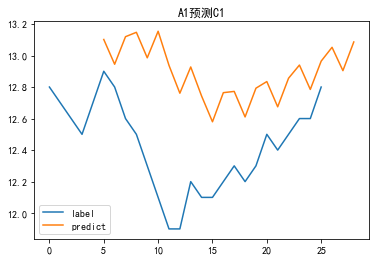

In [25]:
if config.do_predict:

    # 加载模型
    model = Net(config, teacherforcing=False).to(device)
    model.load_state_dict(torch.load(config.model_save_path + config.name + config.model_name))  # 加载模型参数

    # 先定义一个tensor保存预测结果
    result = torch.Tensor().to(device)
    predict_day = config.predict_day
    # 预测过程
    model.eval()
    h_0, c_0 = None, None
    print(encoder_test.shape)
    for _data in test_loader:
        data_X = _data[0].to(device)
        decoder_input0 = data_X[:, -1:, -1:].permute(1, 0, 2)  # 取输入特征的最后一维作为Decoder0的初始输入
        # 因为Predict所以这么设计
        predictTensor = torch.zeros(predict_day - 1, 1, 1).to(device)
        decoder_input = torch.cat((decoder_input0, predictTensor), dim=0)
        # dynamic_input = dynamic_test.permute(1,0,2)

        pred_X = model(data_X, decoder_input, human, nature, h_0, c_0)
        cur_pred = torch.squeeze(pred_X, dim=2)
        result = torch.cat((result, cur_pred), dim=0)
        pred_result = result.detach().cpu().numpy() # 先去梯度信息，如果在gpu要转到cpu，最后要返回numpy数据
    draw(config, data_gainer, logger, pred_result, '_no_roll')

In [ ]:
if __name__ == "__main__":
    import argparse

    # argparse方便于命令行下输入参数，可以根据需要增加更多
    parser = argparse.ArgumentParser()
    # 如果在linux下面, 可以方便采用下面的参数输入
    # 在Windows环境下，可以单独修改参数，直接运行
    parser.add_argument("-b", "--batch_size", default=16, type=int, help="batch size")
    parser.add_argument("-e", "--epoch", default=100, type=int, help="epochs num")
    parser.add_argument("--ttotrain", default=0, type=int, help="1代表训练,0代表测试")
    parser.add_argument("--use_attention", default=1, type=int, help="seq2seq_attention")
    parser.add_argument("--use_static_embedding", default=1, type=int, help="Inite,h0_c0")

    parser.add_argument("--only_dynamic", default=0, type=int, help="只用动态嵌入")
    parser.add_argument("--only_static_concat_dynamic", default=0, type=int, help="静态拼接动态降维")
    parser.add_argument("--only_static_plus_dynamic", default=0, type=int, help="静态和动态直接相加")

    parser.add_argument("--roll_predict_day", default=125, type=int, help="迭代预测天数")  # 相当于让Decoder迭代多少次

    parser.add_argument("--predict_day", default=3, type=int, help="Decoder预测天数")
    parser.add_argument("--time_step", default=5, type=int, help="Encoder读取天数")

    parser.add_argument("--name", default='A1', type=str, help="填写训练预设名称")  # 可以填写'All' 或者'A1,B1,B590_1,B123'这种形式
    parser.add_argument("--val_name", default='C1', type=str, help="填写测试预设名称")  # 填写'C1'这种形式，暂时只支持测试1口井
    # only_dynamic only_static_concat_dynamic only_static_plus_dynamic
    args = parser.parse_args()

    con = Config()
    for key in dir(args):  # dir(args) 函数获得args所有的属性
        if not key.startswith("_"):  # 去掉 args 自带属性，比如__name__等
            setattr(con, key, getattr(args, key))  # 将属性值赋给Config
    # 建议window下，采用下面, 便于调试

    assert con.only_dynamic + con.only_static_concat_dynamic + con.only_static_plus_dynamic <= 1
    # 这几个参数做消融实验时候只能有同时存才1个或者都不存在，就代表动静态融合模块
    sign = True if con.ttotrain == 1 else False
    use_attention = '_No_Attention'
    use_static_embedding = '_hc_False'
    dynamic_fusion = '_ds_fusion'
    if con.only_dynamic == 1:
        dynamic_fusion = '_dynamic_only'
    if con.only_static_concat_dynamic == 1:
        dynamic_fusion = '_concat_only'
    if con.only_static_plus_dynamic == 1:
        dynamic_fusion = '_plus_only'
    if con.use_attention == 1:
        con.use_attention = True
        use_attention = '_Attention'
    else:
        con.use_attention = False
    if con.use_static_embedding == 1:
        con.use_static_embedding = True
        use_static_embedding = '_hc_True'
    else:
        con.use_static_embedding = False
    con.train_name = con.name
    end_sign = '_RMLSE' + str(con.batch_size)
    con.name = con.name + use_attention + use_static_embedding + end_sign + dynamic_fusion + str(con.time_step) + str(
        con.predict_day)
    # 设定名称，用于指示使用方法以及数据
    print('Train:' + str(sign))

    if sign == True:  # 表示训练
        if ',' in con.train_name:
            con.data_selected = con.train_name.split(',')
            print('已选择{}井训练'.format(con.data_selected))
        elif con.train_name == 'All':
            con.data_selected = ['All']
            print('已选择[{}]路径下所有井训练'.format(con.dynamic_data_root))
        else:
            con.data_selected = [con.train_name]  # 只输入单井情况
            print('已选择{}井训练'.format(con.data_selected))
        if not con.train_name:
            assert ('井名输入错误')

        con.train_data_rate = 0.95  # 设定数据用于训练的百分比
        con.add_train = False  # 不加载权重进行训练
        con.do_train = True
        con.do_predict = False
        con.do_predict_roll = False
    else:
        con.data_selected = [con.val_name]
        if not con.train_name:
            assert ('井名输入错误')
        con.train_data_rate = 0.1  # 取井剩下1-train_data_rate的百分比用于测试
        con.do_train = False
        con.do_predict = True
        con.do_predict_roll = False

    main(con)
